## Pair Programming - Regresión lineal 1

### Intro Machine Learning

---

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


Empezamos una nueva lección, y este es el momento de poner en práctica los conocimientos adquiridos sobre la Regresión Lineal Simple I. Para ello os vamos a pedir que por vuestra cuenta busqueis un dataset que os guste, por ejemplo de Kaggle o de donde queráis extraerlo. De forma que vamos a probar a realizar ajustes lineales con el fin de predecir alguna de sus variables. Este dataset será el que iremos usando a lo largo de todas las sesiones de pairprogramming de regresión lineal.

Se ruega a la hora de realizar la entrega que incluyais el conjunto de datos que hayais decidido emplear para estos ejercicios.

## Objetivos

Los objetivos de hoy son:

1. Buscar un conjunto de datos a analizar:

    - Es necesario que el conjunto de datos a analizar tenga variables numéricas y categóricas, primando que haya más de una variable de tipo numérico. Ya que tambien se utilizarán serán útiles a la hora de realizar predicciones en las clases de regresión lineal múltiple. Así mismo se recomienda que los datasets esten ligeramente limpios para facilitar los análisis.

In [289]:
df = pd.read_csv('../archivos/Metro_Interstate_Traffic_Volume.csv.gz')

In [290]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


La variable respuesta será 'traffic_volume' y las variables predictoras serán las demás.

---

2. Explicar los datos y las variables disponibles en el conjunto de datos seleccionado:

    - Esto se hace para que comprendais mejor los datos con los que estais trabajando.
    - Realizar un EDA sencillo para la variable dependiente y la variable independiente.

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [292]:
df.shape

(48204, 9)

In [293]:
df.duplicated().sum() # Como vemos que hay 17 filas duplicados decidimos eliminarlos

17

In [294]:
df.drop_duplicates(inplace=True)

In [295]:
df.shape

(48187, 9)

In [296]:
df.describe().T #variables numéricas

,count,mean,std,min,25%,50%,75%,max
temp,48187.0,281.204995,13.338738,0.0,272.16,282.45,291.806,310.07
rain_1h,48187.0,0.334382,44.797033,0.0,0.00,0.00,0.000,9831.30
snow_1h,48187.0,0.000222,0.008169,0.0,0.00,0.00,0.000,0.51
clouds_all,48187.0,49.365451,39.015213,0.0,1.00,64.00,90.000,100.00
traffic_volume,48187.0,3259.618134,1986.954465,0.0,1192.50,3379.00,4933.000,7280.00


In [297]:
df.describe(include='object').T #variables categóricas

,count,unique,top,freq
holiday,48187,12,None,48126
weather_main,48187,11,Clouds,15158
weather_description,48187,38,sky is clear,11659
date_time,48187,40575,2013-04-18 22:00:00,6


In [298]:
df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [299]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

_____________

Procedemos a una limpieza más exaustiva teniendo en cuenta nuestra nueva Hipótesis, que se va a centrar en cual de las variables (día y hora) influye más en el volumen de personas en el metro.

In [300]:
df.head(1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545


### Recategorizamos "holiday" como Si o No, poniendo Si como 1 y No como 0.

In [301]:
def festivos(col):
    if col == "None":
        return 0
    else:
        return 1

In [302]:
df["holiday_cat"]= df["holiday"].apply(festivos)

In [303]:
df["holiday_cat"].value_counts()

0    48126
1       61
Name: holiday_cat, dtype: int64

In [304]:
#Borramos la columna holiday al tener la información mejor categorizada en otra columna
df.drop('holiday', axis=1, inplace=True)

### Recategorizamos la columna date_time para crear una nueva solo con la hora. 

In [305]:
df[["date","time"]]= df["date_time"].str.split(expand=True)


In [306]:
#Borramos la columna date_time al tener la información separada en dos columnas
df.drop('date_time', axis=1, inplace=True)

### Creamos una nueva columna a través de la fecha para obtener los días de la semana

In [307]:
def dia_semana(col):
    return col.isoweekday()

In [308]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [309]:
df["weekday"]= df["date"].apply(dia_semana)


In [310]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,holiday_cat,date,time,weekday
0,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,0,2012-10-02,09:00:00,2
1,289.36,0.0,0.0,75,Clouds,broken clouds,4516,0,2012-10-02,10:00:00,2
2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,0,2012-10-02,11:00:00,2
3,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,0,2012-10-02,12:00:00,2
4,291.14,0.0,0.0,75,Clouds,broken clouds,4918,0,2012-10-02,13:00:00,2


### Transformamos la columna temp de grados kelvin a celsius 

Analizando la columna y vemos que hay once registros de 0.0 kelvin. Estudiamos las temperaturas de ese día en diferentes horas e intuimos que son errores de registro, ya que el resto de temperatura ronda los 255 grados.
Decidimos no borralos para mantener el resto de datos y reemplazarlo por la misma temperatura de la hora de antes y la hora de después. 

In [311]:
def celsius(col):
    if col == 0:
        return -17
    else:
        return col -273.15

In [312]:
df['temp_c'] = df['temp'].apply(celsius)

### Definimos las columnas con las que seguimos haciendo el EDA, normalización y demás procesos.

In [313]:
df_2 = df[['date', 'weekday', 'time', 'holiday_cat', 'temp_c', 'snow_1h', 'traffic_volume']]
df_2.head()

,date,weekday,time,holiday_cat,temp_c,snow_1h,traffic_volume
0,2012-10-02,2,09:00:00,0,15.13,0.0,5545
1,2012-10-02,2,10:00:00,0,16.21,0.0,4516
2,2012-10-02,2,11:00:00,0,16.43,0.0,4767
3,2012-10-02,2,12:00:00,0,16.98,0.0,5026
4,2012-10-02,2,13:00:00,0,17.99,0.0,4918


---

In [314]:
numericas= df_2.select_dtypes(include= np.number).columns.tolist()
print(numericas)

['weekday', 'holiday_cat', 'temp_c', 'snow_1h', 'traffic_volume']


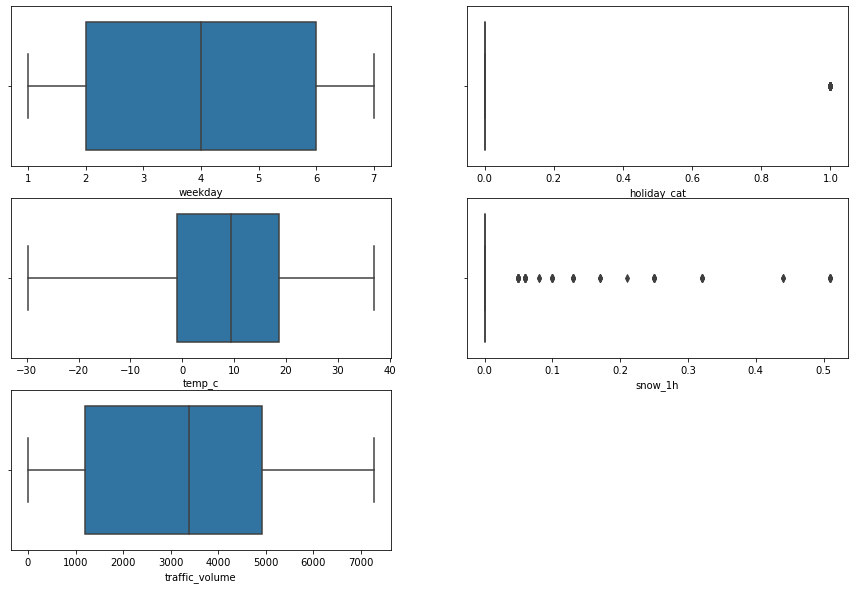

In [315]:
# Gráficas para ver los outliers de cada variable numérica

fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes = axes.flat

for i,col in enumerate(numericas):
  
    sns.boxplot(x= col, data=df_2, ax=axes[i])
    
fig.delaxes(axes[-1])

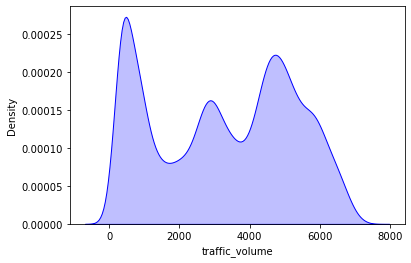

In [316]:
# Gráfica para ver como está distribuida la variable respuesta

sns.distplot(
    df_2["traffic_volume"], 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

In [317]:
df_2[df_2['traffic_volume'] < 1]
#Filtramos la variable respuesta para encontrar los registros negativos pero no aparecen.. 

,date,weekday,time,holiday_cat,temp_c,snow_1h,traffic_volume
25186,2016-07-23,6,18:00:00,0,23.53,0.0,0
25191,2016-07-23,6,23:00:00,0,22.75,0.0,0


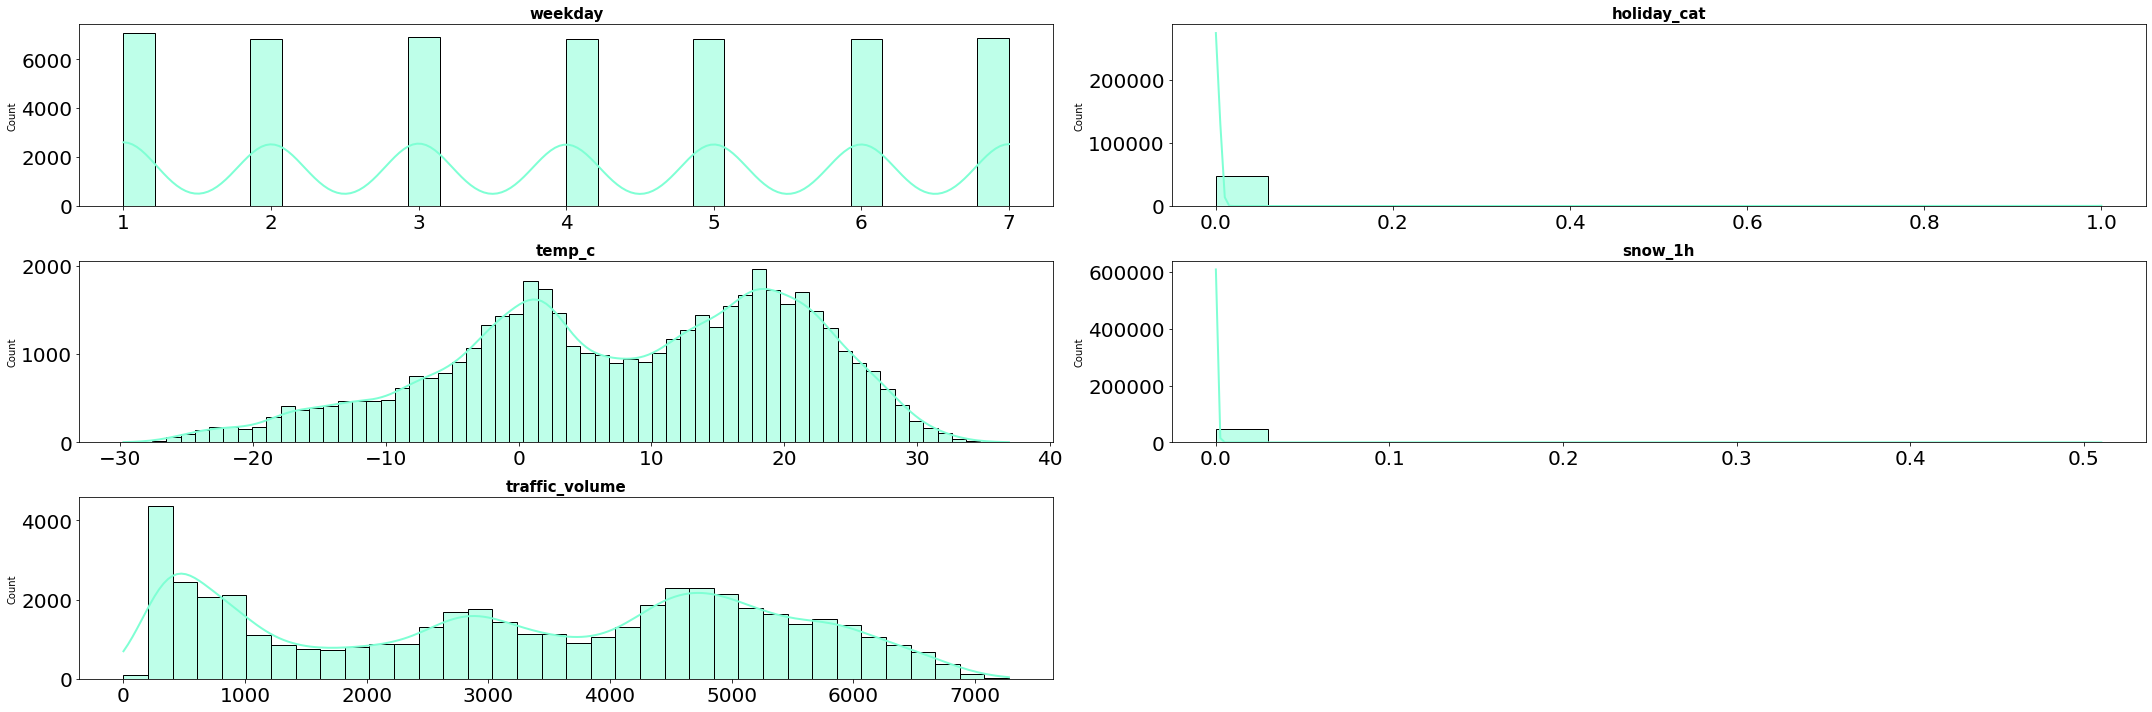

In [318]:
# Gráficas de distribución para cada variable numérica

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (30, 10))

axes = axes.flat

for i, colum in enumerate(numericas): 
    sns.histplot(
        data = df_2,
        x = colum,
        kde = True, 
        color = "aquamarine", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
   
fig.delaxes(axes[-1])
fig.tight_layout();


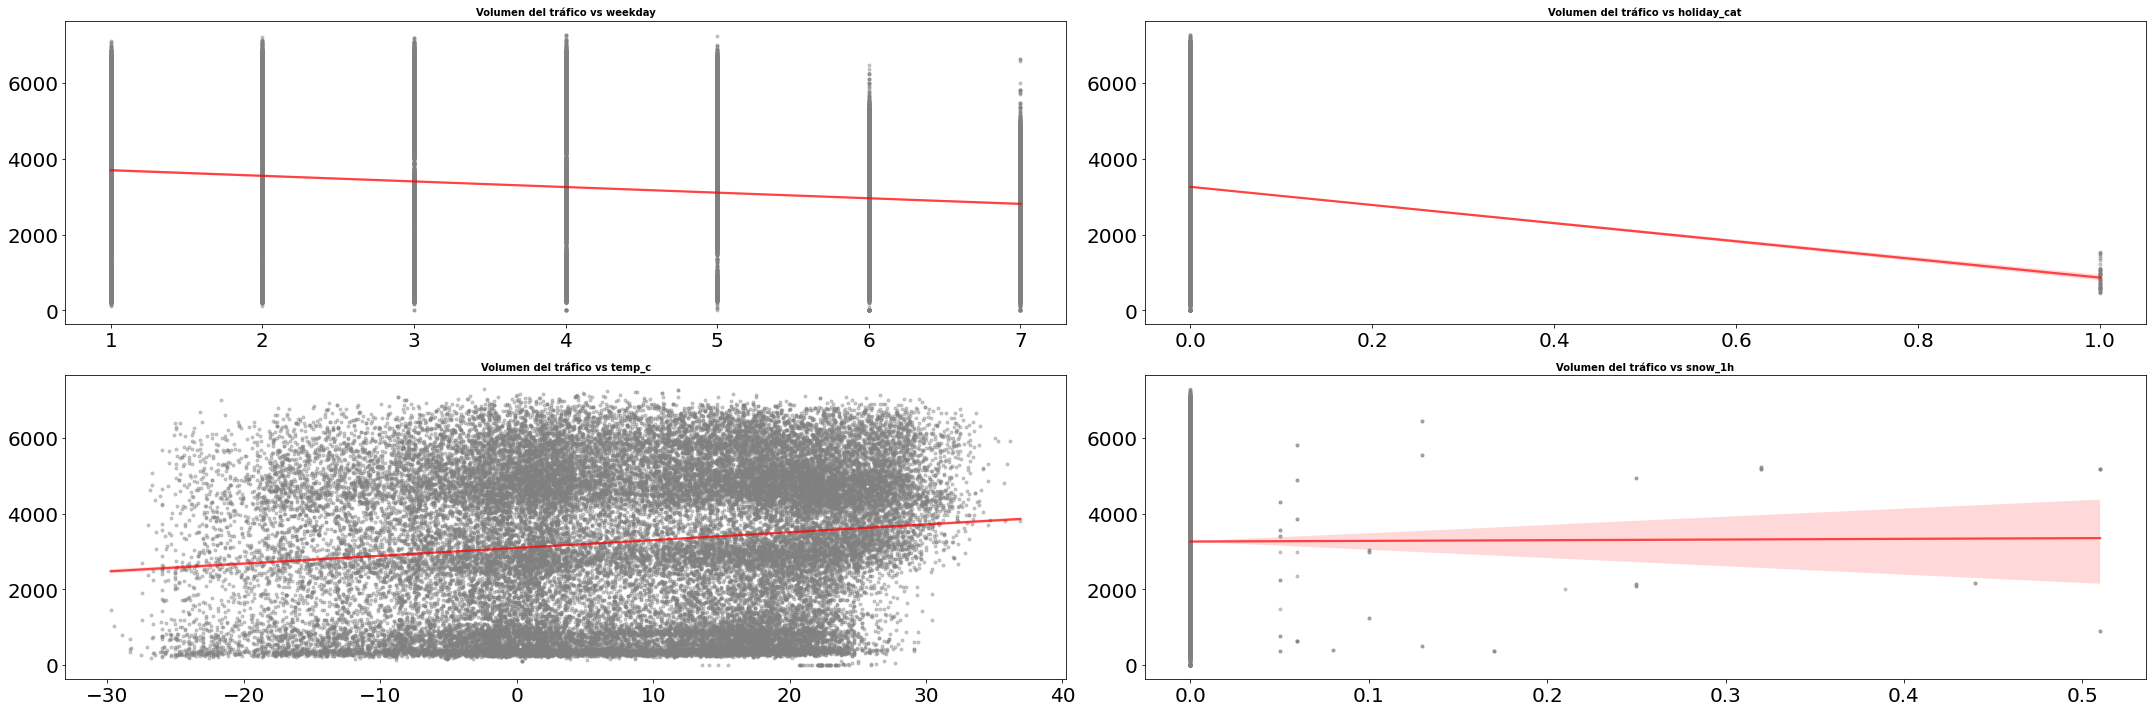

In [319]:
# Gráficas de relación entre variables predictoras y la variable a predecir

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))

axes = axes.flat

numericas= numericas[:-1]

for i, colum in enumerate(numericas):
    sns.regplot(
        x = df_2[colum], 
        y = df_2["traffic_volume"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Volumen del tráfico vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

#fig.delaxes(axes[-1])    
fig.tight_layout();

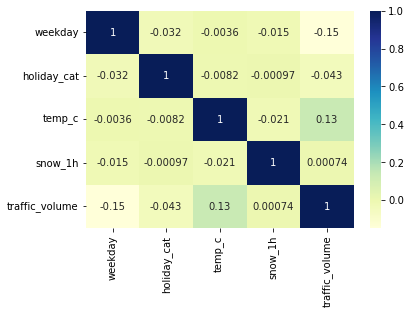

In [320]:
# Gráfica para ver la correlación entre variables

sns.heatmap(df_2.corr(), 
           cmap = "YlGnBu", 
           annot = True);

In [321]:
df_2.to_csv("../archivos/metro_A.csv")